# Analyzing Amazon.com 130+ million customer review data using SageMaker and Athena

1. [Introduction](#Introduction)
2. [Topic-based unsupervised review grouping](#Topic-based unsupervised review grouping)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)

# Introduction

This notebook demonstrates the analysis of Amazon review data using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) in two parts. The first part uses [LDA](https://docs.aws.amazon.com/sagemaker/latest/dg/lda.html) and [K-Means](https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html) algorithms to automatically group together reviews based on topics discussed within the text. The second part covers predicting review scores using [Linear Learner](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) and [Factorization Machine](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines.html) based on contents of the review. The end shows how to predict the rating of a new review based on the models.

In [1]:
# Define IAM role
import os
import boto3
import time
import re
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'pilho-lab-us-east-1'
prefix = 'amazonreview'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://pilho-lab-us-east-1/amazonreview/train
Validation set location s3://pilho-lab-us-east-1/amazonreview/val
Trained model will be saved at s3://pilho-lab-us-east-1/amazonreview/output


### Data ingestion

For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets. We will use Amazon.com review open data available at https://s3.amazonaws.com/amazon-reviews-pds/readme.html More classified data is available at http://jmcauley.ucsd.edu/data/amazon/

Let's first see what are included in `amazon-reviews-pdf` s3 bucket.

In [2]:
s3 = boto3.resource('s3')
sourceBucket = s3.Bucket('amazon-reviews-pds')

#for obj in sourceBucket.objects.all():
#    print(obj.key)

The above results shows how billions of review data are stored as an object in S3. Let's import them into Athena and perform SQL queries to get more details. Follow the instruction at https://s3.amazonaws.com/amazon-reviews-pds/readme.html. This lab does not handle this importing part. 

After finishing importing, you can perform a SQL query. The below screenshot shows one example. For your information, Athena's query results are automatically saved back to S3. Let's utilize one of the result. Note to set the property of a target CSV as a public readable.

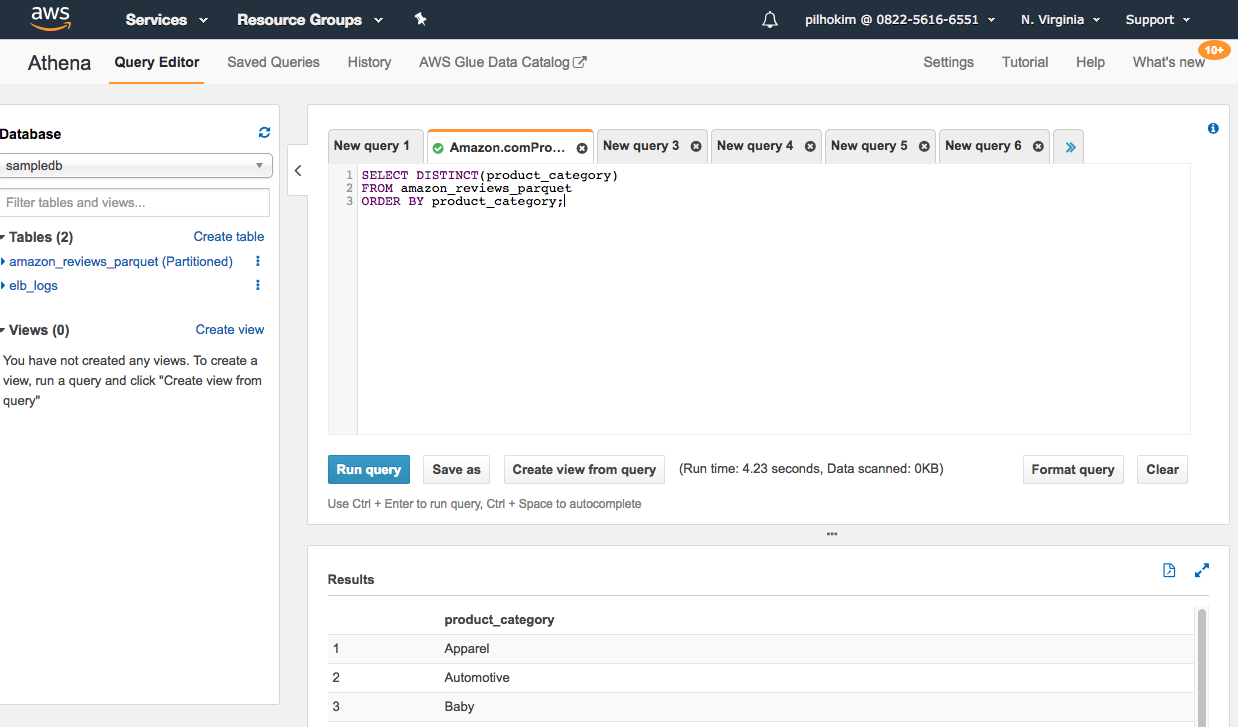

Athena SQL query

```sql
SELECT DISTINCT(product_category)
FROM amazon_reviews_parquet
ORDER BY product_category;
```

In [3]:
display(role)

'arn:aws:iam::082256166551:role/service-role/AmazonSageMaker-ExecutionRole-20180110T104784'

In [4]:
role_array = role.split('/')
role_name = role_array[len(role_array) - 1]
print(role_name)

AmazonSageMaker-ExecutionRole-20180110T104784


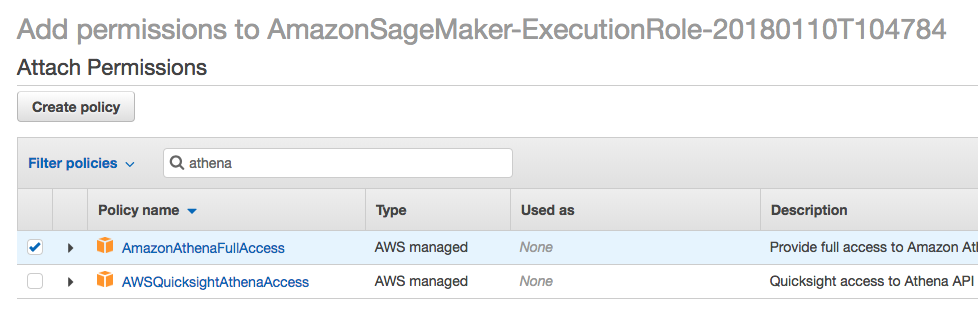

We need to add permissions to our SageMaker role (in this case 'AmazonSageMaker-ExecutionRole-20180110T104784') to perform queries using Athena. Go to the IAM console and add AmazonAthenaFullAccess  like the above screenshot. We will also give a full S3 access priviledge to allow this code to access partitioned S3 buckets.



![AddS3FullAccessPermition.png](images/AddS3FullAccessPermition.png)

In [5]:
#iam_client = boto3.client('iam')

#sagemaker_role = iam_client.get_role(RoleName=role_name)
#display(sagemaker_role)

#role_attach_response = iam_client.attach_role_policy(
#    RoleName=role_name,
#    PolicyArn='arn:aws:iam::aws:policy/AmazonAthenaFullAccess'
#)

#print(role_attach_response)

We don't automate this part using boto3 IAM APIs because then we have to give a IAM permision to SageMaker's role which might be less safe than manually assign the role only when necessary. Just in case you want to automate this part, a sample code is given above.

Also note that above IAM role changes may take a few minutes to be effective.

Let's write a few utility codes for Athena query interaction. The below code is originated from https://github.com/quentinf00/API-S3-Lambda/blob/bb5d279396195acfa113f4f074587d714e4ed504/athena.py

In [6]:
'''
The original code comes from https://github.com/quentinf00/API-S3-Lambda/blob/bb5d279396195acfa113f4f074587d714e4ed504/athena.py

It is modified and enhanced by Pil Ho Kim for this demonstration, 2nd August 2018
'''
import os
import boto3
from time import sleep

# This is the new bucket that stores the query results
RESULT_BUCKET = 'aws-athena-query-results-082256166551-us-east-1'
DB = 'sampledb'

athena = boto3.client('athena')

# This is the function that start the execution and get the results
def get_results(query, database=DB):
    query_id = hash(query)

    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': f's3://{RESULT_BUCKET}/{query_id}'
        }
    )

    results = get_query_results(response['QueryExecutionId'])
    return results

# This is the function that start the execution and get the results
def get_results_for_pd(query, database=DB):
    query_id = hash(query)

    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': f's3://{RESULT_BUCKET}/{query_id}'
        }
    )

    results = get_query_results_for_pd(response['QueryExecutionId'])
    return results

# This query does not return the result set but the address of newly created S3 bucket with a key name
# Mostly used for a query result too big to display and for the use of ML training
def get_results_in_s3(query, database=DB):
    query_id = hash(query)
    s3_output_location = f's3://{RESULT_BUCKET}/{query_id}'
    
    response = athena.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
        },
        ResultConfiguration={
            'OutputLocation': s3_output_location
        }
    )
    
    run_result = get_query_results_in_s3(response['QueryExecutionId'])
    s3_output_location = run_result['response']['QueryExecution']['ResultConfiguration']['OutputLocation']
    return s3_output_location

#This function polls the state of the query execution each second and fetches the results once it's finished
def get_query_results(exec_id):
    run_status = False
    
    while(not run_status):
        current_status = is_execution_done(exec_id)
        run_status = current_status['status']
        print('not done yet')
        sleep(1)

    results = athena.get_query_results(
        QueryExecutionId=exec_id,
    )
    #print(results)

    return format_result(results)

#This function polls the state of the query execution each second and fetches the results once it's finished
def get_query_results_for_pd(exec_id):
    run_status = False
    
    while(not run_status):
        current_status = is_execution_done(exec_id)
        run_status = current_status['status']
        print('not done yet')
        sleep(1)

    results = athena.get_query_results(
        QueryExecutionId=exec_id,
    )
    #print(results)

    return format_result_for_pd(results)

#This function polls the state of the query execution each second and fetches the results once it's finished
def get_query_results_in_s3(exec_id):
    run_status = False
    
    while(not run_status):
        current_status = is_execution_done(exec_id)
        run_status = current_status['status']
        print('not done yet')
        sleep(1)

    athena.get_query_results(
        QueryExecutionId=exec_id,
    )

    return current_status

# This function checks the state of the execution, returns true if it is SUCCEEDED
def is_execution_done(exec_id):
    response = athena.get_query_execution(
        QueryExecutionId=exec_id,
    )
    
    if response['QueryExecution']['Status']['State'] == 'FAILED':
        display(response)
        raise Exception('Failed Athena query')

    # display(response)
    
    return {
        'response': response,
        'status': response['QueryExecution']['Status']['State'] == 'SUCCEEDED'
    }
        

# This functions just parses the rows and return a list of dictionnaries
def format_result(results):
    columns = [
        col['Label']
        for col in results['ResultSet']['ResultSetMetadata']['ColumnInfo']
    ]

    formatted_results = []

    for result in results['ResultSet']['Rows'][1:]:
        values = [list(field.values())[0] for field in result['Data']]

        formatted_results.append(
            dict(zip(columns, values))
        )

    return formatted_results

# This functions just parses the rows and return a list of dictionnaries
def format_result_for_pd(results):
    columns = [
        col['Label']
        for col in results['ResultSet']['ResultSetMetadata']['ColumnInfo']
    ]

    formatted_results = []

    for result in results['ResultSet']['Rows'][1:]:
        values = [list(field.values())[0] for field in result['Data']]

        formatted_results.append(
            dict(zip(columns, values))
        )

    return formatted_results

Let's create an Athena table based on the instruction at https://s3.amazonaws.com/amazon-reviews-pds/readme.html

In [7]:
query_results = get_results(f"""
CREATE EXTERNAL TABLE IF NOT EXISTS sampledb.amazon_reviews_parquet_query(
  marketplace string, 
  customer_id string, 
  review_id string, 
  product_id string, 
  product_parent string, 
  product_title string, 
  star_rating int, 
  helpful_votes int, 
  total_votes int, 
  vine string, 
  verified_purchase string, 
  review_headline string, 
  review_body string, 
  review_date bigint, 
  year int)
PARTITIONED BY (product_category string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://amazon-reviews-pds/parquet/'
    """)
print(query_results)

not done yet
not done yet
[]


In [8]:
query_results = get_results(f"""
    MSCK REPAIR TABLE amazon_reviews_parquet_query
""")
print(query_results)

not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
[]


In [9]:
query_results = get_results(f"""
    SHOW TABLES IN sampledb
""")
print(query_results)

not done yet
not done yet
[{'tab_name': 'amazon_reviews_parquet_query'}, {'tab_name': 'amazon_reviews_parquet_rev1'}, {'tab_name': 'elb_logs'}]


# Statistical Preview on Amazon Review Data

In [10]:
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
import numpy as np

## How many customers have contributed to the review  in the current data set?

In [11]:
query_results = get_results(f"""
    SELECT COUNT(DISTINCT(customer_id)) FROM amazon_reviews_parquet_query
""")
display(query_results)

not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet


[{'_col0': '34940792'}]

## How many product categories and each associcated review data exist?

In [12]:
query_results = get_results(f"""
    SELECT 
        product_category,
        COUNT(*) AS data_count
    FROM amazon_reviews_parquet
    GROUP BY product_category
""")
display(query_results)

not done yet
not done yet
not done yet
not done yet
not done yet


[{'product_category': 'Wireless', 'data_count': '9038249'},
 {'product_category': 'Shoes', 'data_count': '4379475'},
 {'product_category': 'Mobile_Electronics', 'data_count': '105159'},
 {'product_category': 'Home', 'data_count': '6228567'},
 {'product_category': 'Camera', 'data_count': '1838760'},
 {'product_category': 'PC', 'data_count': '7004337'},
 {'product_category': 'Major_Appliances', 'data_count': '96901'},
 {'product_category': 'Apparel', 'data_count': '5906460'},
 {'product_category': 'Music', 'data_count': '6177781'},
 {'product_category': 'Jewelry', 'data_count': '1767753'},
 {'product_category': 'Kitchen', 'data_count': '4882831'},
 {'product_category': 'Mobile_Apps', 'data_count': '6807166'},
 {'product_category': 'Health_&_Personal_Care', 'data_count': '5332883'},
 {'product_category': 'Home_Improvement', 'data_count': '2640654'},
 {'product_category': 'Luggage', 'data_count': '349132'},
 {'product_category': 'Toys', 'data_count': '4981601'},
 {'product_category': 'Vide

In [13]:
distinct_category_counter_s3_address = get_results_in_s3(f"""
    SELECT 
        product_category,
        COUNT(*) AS data_count
    FROM amazon_reviews_parquet
    GROUP BY product_category
""")
display(distinct_category_counter_s3_address)

not done yet
not done yet
not done yet
not done yet
not done yet
not done yet
not done yet


's3://aws-athena-query-results-082256166551-us-east-1/9004109121025105642/917fc55f-b407-4188-9dde-d8f506e94eac.csv'

In [14]:
data = pd.read_csv(distinct_category_counter_s3_address)
display(data)

,product_category,data_count
0,Apparel,5906460
1,Digital_Music_Purchase,1852184
2,Gift_Card,149086
3,Baby,1764893
4,Health_&_Personal_Care,5332883
5,Home_Improvement,2640654
6,Digital_Video_Download,5173743
7,Tools,1748610
8,Electronics,3120938
9,Digital_Ebook_Purchase,19180765


In [15]:
# Let's sort data
sorted_data = data.sort_values(['data_count'], ascending=[0])

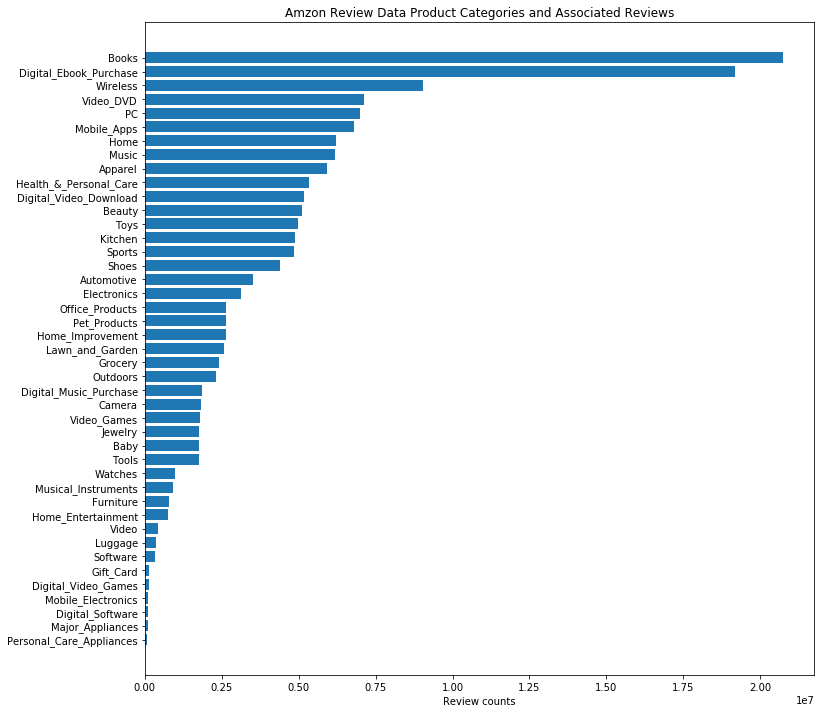

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
y_pos = np.arange(len(sorted_data['product_category']))

ax.barh(y_pos, sorted_data['data_count'])
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_data['product_category'])
ax.invert_yaxis()
ax.set_xlabel('Review counts')
ax.set_title('Amzon Review Data Product Categories and Associated Reviews')

plt.show()

# Preparing Data for ML Training

Firstly, let's get a preview on the data set using Athena to get some insights on the preprocessing for ML training.

```sql
SELECT *
FROM amazon_reviews_parquet
WHERE product_category = 'Books'
LIMIT 10000
```

In [17]:
preview_data_s3_address = get_results_in_s3(f"""
    SELECT *
    FROM amazon_reviews_parquet
    WHERE product_category = 'Books'
    LIMIT 10000
""")
print(preview_data_s3_address)

not done yet
not done yet
not done yet
not done yet
s3://aws-athena-query-results-082256166551-us-east-1/6561954570771475933/7924b2f0-187b-46dc-821b-7debf49c4cf7.csv


In [18]:
preview_data = pd.read_csv(preview_data_s3_address)
display(preview_data)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category
0,US,38979701,R1HLR6XLZKFPHI,1606530569,577328083,Bigfoot Blues,5,0,0,N,N,"A bar, a babe, and a Bigfoot--but not what you...",We too often fail to see the love and joy that...,15795,2013,Books
1,US,21411418,ROZHG1KO45JJV,0425208842,355969221,Shadow Prey (A Prey Novel),5,0,0,N,Y,The Prey Series by John Sandford,I have yet to find a John Sandford book that I...,15795,2013,Books
2,US,46579740,R2MZZF36HGOQNM,1583331387,141937733,A Natural Guide to Pregnancy and Postpartum He...,4,2,2,N,Y,Solid for newcomers to pregnancy and birth,I am a childbirth instructor. I bought this b...,15795,2013,Books
3,US,51737466,R172Z1DC2FKDUM,0307200612,165056974,Things That Go (Little Golden Peg Puzzle Books),4,0,0,N,Y,Srosxi's Review,I thought the product was exactly what I neede...,15795,2013,Books
4,US,20199159,RO5DTZ1PXG3RO,0595508995,96141859,Saturday or Sunday: Which Is the Sabbath?,2,1,3,N,Y,FALSE!,"Great transaction, but I do not believe what i...",15795,2013,Books
5,US,33722299,R3TDZQQMB3DGAR,0786754133,165757535,Was Michæl Jackson Framed?: The Untold Story T...,3,6,9,N,N,Shocked and sad to see false information in th...,This article has been cherished by Michael Jac...,15795,2013,Books
6,US,49987172,R2Z8BZUUVC19TE,1401212816,88240103,Batman and the Mad Monk,5,0,0,N,Y,Great read,"Thought the book was great.But,Im a huge Batma...",15795,2013,Books
7,US,29376116,R15O0G7SYRP7I6,0062019457,740687630,Dark Fire (Dark Series),5,0,0,N,Y,Dark Fire,This is a great book. It's fantasy book. It's ...,15795,2013,Books
8,US,36650176,RO4F0XH0BJXN2,1442429844,890073360,A Whale of a Tale (Mermaid Tales),4,3,4,N,Y,Cute!,My 3 and 5 year old enjoy listening to me read...,15795,2013,Books
9,US,43482820,RLFJDY2XUY0G2,1612184650,775497681,The Bloodletter's Daughter (A Novel of Old Boh...,1,24,26,N,N,Literally one of the worst books I've ever read,I wish I could get back the hours of my life w...,15795,2013,Books


The above data includes strings which should be converted and/or filtered out. Let's reformulate our query.

```sql
SELECT 
    product_category,
    product_id,
    product_title,
    customer_id,
    star_rating,
    CASE WHEN star_rating >= 4.0 THEN 'positive'
         WHEN star_rating <= 2.0 THEN 'negative'
         ELSE 'neural'
    END as rate_category,
    year,
    review_date,
    review_body
FROM amazon_reviews_parquet
WHERE product_category = 'Books'
LIMIT 10000
```

In [19]:
preview_data_s3_address = get_results_in_s3(f"""
    SELECT 
        product_category,
        product_id,
        product_title,
        customer_id,
        star_rating,
        CASE WHEN star_rating >= 4.0 THEN 'positive'
             WHEN star_rating <= 2.0 THEN 'negative'
             ELSE 'neural'
        END as rate_category,
        year,
        review_date,
        review_body
    FROM amazon_reviews_parquet
    WHERE product_category = 'Books' AND LENGTH(review_body) > 10
    LIMIT 10000
""")
print(preview_data_s3_address)

not done yet
not done yet
not done yet
s3://aws-athena-query-results-082256166551-us-east-1/3534975015271563717/97877883-c406-450a-baab-100a7ea11735.csv


In [20]:
# 1000000 review samples: 745.4 MB
source_data = pd.read_csv(preview_data_s3_address)
display(source_data)

,product_category,product_id,product_title,customer_id,star_rating,rate_category,year,review_date,review_body
0,Books,0312376995,The Urban Hermit: A Memoir,43318462,4,positive,2008,14228,"The Urban Hermit is a quick, clever, and somet..."
1,Books,0813031532,The Fosse Style,48826075,5,positive,2008,14228,As a fan of Fosse's work I have always been in...
2,Books,1514372908,Bolt Hole by the Sea: An Unexpected Life on a ...,26114026,5,positive,2015,16660,an American learning about a way of life on an...
3,Books,0884692558,Soul Physicians,50364349,5,positive,2008,14228,"I found \\""Soul Physicians\\"" to be a useful t..."
4,Books,1600512879,Teaching from Rest: A Homeschooler's Guide to ...,45049562,5,positive,2015,16660,I am so glad that this book is now available i...
5,Books,1419616528,Myths We Live By : From the times of Jesus and...,52754940,5,positive,2008,14228,This book is very fascinating but only if one ...
6,Books,1478927925,And the Good News Is...: Lessons and Advice fr...,44056163,3,neural,2015,16660,I've always liked Dana Perino but the audioboo...
7,Books,1602392730,Don't Start the Revolution Without Me!,9893178,4,positive,2008,14228,Jesse's format for this book is a little chees...
8,Books,0374123047,Notes on the Death of Culture: Essays on Spect...,13161706,3,neural,2015,16660,Author Llosa begins by summarizing T.S. Eliot'...
9,Books,0738702870,Grimoire for the Green Witch: A Complete Book ...,13241027,5,positive,2008,14228,I absolutely love this book. Great source for ...


# Topic-based unsupervised review grouping

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

## Import review data
Amazon reviews can span from 1 star to 5 stars. The difference between a 1-2 or a 4-5 might be very noisy when we build predictions. Instead, we bucket reviews by:
- Low: 1-2 Stars
- Neutral: 3 Stars
- High: 4-5 Stars

Reviews are filtered to those with at least 45 words to avoid short, uninformative reviews like "This is great!". After limiting, we take a stratified sample of 6000 reviews from each bucket to get reasonable performance from sklearn in Python. The stratification helps us overcome the bias in that 80% of the reviews have 4-5 star ratings.

## Calculate Term Frequencies
We calculate both the actual term frequency as well as the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (short for term frequency–inverse document frequency) weighted term frequency. For both algorithms, we limit to words occuring in at most 90% of documents and in at least 10 documents. While the term-frequency matrix is just a word count, the IDF calculation adjusts for "boring" words that occur in many reviews.

We perform two tokenizing operations. First, we tokenize only letters, ignoring special symbols & numbers. We use the NLTK Snowball stemmer to try and get the root of a word as best as possible. Stop words are removed in the vectorization step.

For details on Scikit-learn text feature extraction, see http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction.

In [22]:
# Install natural language toolkit
!pip install -U msgpack
!pip install -U nltk

Requirement already up-to-date: msgpack in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (0.5.6)
mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: nltk in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (3.3)
Requirement not upgraded as not directly required: six in /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from nltk) (1.11.0)
mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not instal

In [23]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 10 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

In [25]:
# Install debug tools. Let's not do this now. Just keep this line for the information
# !pip install pixiedust

In [30]:
# Ensure that all data is encoded to UTF-8 based on https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
raveld_source_data = source_data['review_body'].ravel()

display(raveld_source_data[0].lower())
display(raveld_source_data.shape)

'the urban hermit is a quick, clever, and sometimes laugh-out-loud funny book. sam macdonald is in his late 20s when the life that he\'s always enjoyed (drinking, hanging out, not really caring about money) comes to a grinding halt when he discovers how much money he owes to the irs and credit card companies. he decides to try an \\\\"urban hermit\\\\" plan for month, where he exists on the cheapest food possible (tuna, eggs and lentils) while saving up money to pay his creditors back. unlike a lot of other memoirs where the author decides to follow some self-improvement plan for a year, macdonald originally plans on being an urban hermit for only a month. due to a series of unforeseen events, he ends up being an urban hermit (with some breaks) for many, many months. during that time, we see him travel to bosnia for a reporting job, bust a porn shop for illegal viewing booths, save a trailer park, travel to a huge hippie gathering in montana, get what sounds like his first real girlfri

(10000,)

Let's firstly build up a word counter that produces vectors from input review texts.

In [27]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()

vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
                            tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)
#vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
#                             tokenizer=LemmaTokenizer(), max_df=0.95, min_df=2)

vectors = vectorizer.fit_transform(raveld_source_data)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...
vocab size: 2000
Done. Time elapsed: 12.88s


In [28]:
print(vectors.shape)

(10000, 2000)


In [29]:
threshold = 25
vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
print('removed short docs (<{} words)'.format(threshold))        
print(vectors.shape)

removed short docs (<25 words)
(271, 2000)


Because all the parameters (weights and biases) in the NTM model are `np.float32` type we'd need the input data to also be in `np.float32`. It is better to do this type-casting upfront rather than repeatedly casting during mini-batch training.

In [41]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In [42]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [43]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(216, 2000) (28, 2000) (27, 2000)


In [44]:
import io
import numpy as np
import sagemaker.amazon.common as smac
import boto3
import os

#trainVectors = np.array([t.tolist() for t in train_X]).astype('float32')
#trainLabels = np.where(np.array([t.tolist() for t in train_y]) == 0, 1, 0).astype('float32')

bucket = 'pilho-sagemaker-ai-workshop'
prefix = 'amazonreview'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://pilho-sagemaker-ai-workshop/amazonreview/train
Validation set location s3://pilho-sagemaker-ai-workshop/amazonreview/val
Trained model will be saved at s3://pilho-sagemaker-ai-workshop/amazonreview/output


In [50]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [46]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part0.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part1.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part2.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part3.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part4.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part5.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part6.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/train/train_part7.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/val/val_part0.pbr


---
# Model Training

We have created the training and validation data sets and uploaded them to S3. Next, we configure a SageMaker training job to use the NTM algorithm on the data we prepared

SageMaker uses Amazon Elastic Container Registry (ECR) docker container to host the NTM training image. The following ECR containers are currently available for SageMaker NTM training in different regions. For the latest Docker container registry please refer to [Amazon SageMaker: Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [47]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'ntm')

The code in the cell below automatically chooses an algorithm container based on the current region. In the API call to `sagemaker.estimator.Estimator` we also specify the type and count of instances for the training job. Because the 20NewsGroups data set is relatively small, we have chosen a CPU only instance (`ml.c4.xlarge`), but do feel free to change to [other instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/). NTM fully takes advantage of GPU hardware and in general trains roughly an order of magnitude faster on a GPU than on a CPU. Multi-GPU or multi-instance training further improves training speed roughly linearly if communication overhead is low compared to compute time.

In [48]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## Hyperparameters

Here we highlight a few hyperparameters. For information about the full list of available hyperparameters, please refer to [NTM Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm_hyperparameters.html).

- **feature_dim** - the "feature dimension", it should be set to the vocabulary size
- **num_topics** - the number of topics to extract
- **mini_batch_size** - this is the batch size for each worker instance. Note that in multi-GPU instances, this number will be further divided by the number of GPUs. Therefore, for example, if we plan to train on an 8-GPU machine (such as `ml.p2.8xlarge`) and wish each GPU to have 1024 training examples per batch, `mini_batch_size` should be set to 8196.
- **epochs** - the maximal number of epochs to train for, training may stop early
- **num_patience_epochs** and **tolerance** controls the early stopping behavior. Roughly speaking, the algorithm will stop training if within the last `num_patience_epochs` epochs there have not been improvements on validation loss. Improvements smaller than `tolerance` will be considered non-improvement.
- **optimizer** and **learning_rate** - by default we use `adadelta` optimizer and `learning_rate` does not need to be set. For other optimizers, the choice of an appropriate learning rate may require experimentation.

In [49]:
num_topics = 20
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

Next, we need to specify how the training data and validation data will be distributed to the workers during training. There are two modes for data channels:

- `FullyReplicated`: all data files will be copied to all workers
- `ShardedByS3Key`: data files will be sharded to different workers, i.e. each worker will receive a different portion of the full data set.

At the time of writing, by default, the Python SDK will use `FullyReplicated` mode for all data channels. This is desirable for validation (test) channel but not suitable for training channel. The reason is that when we use multiple workers we would like to go through the full data set by each of them going through a different portion of the data set, so as to provide different gradients within epochs. Using `FullyReplicated` mode on training data not only results in slower training time per epoch (nearly 1.5X in this example), but also defeats the purpose of distributed training. To set the training data channel correctly we specify `distribution` to be `ShardedByS3Key` for the training data channel as follows.

In [50]:
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 

Now we are ready to train. The following cell takes a few minutes to run. The command below will first provision the required hardware. You will see a series of dots indicating the progress of the hardware provisioning process. Once the resources are allocated, training logs will be displayed. With multiple workers, the log color and the ID following `INFO` identifies logs emitted by different workers.

In [51]:
ntm.fit({'train': s3_train, 'test': s3_val_data})

INFO:sagemaker:Creating training-job with name: ntm-2018-08-03-02-14-58-933


...........................
Docker entrypoint called with argument(s): train
[08/03/2018 02:19:14 INFO 140274751190848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.01', u'_data_format': u'record', u'epochs': u'50', u'weight_decay': u'0.0', u'_num_kv_servers': u'auto', u'encoder_layers_activation': u'sigmoid', u'mini_batch_size': u'256', u'tolerance': u'0.001', u'batch_norm': u'false'}
[08/03/2018 02:19:14 INFO 140274751190848] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'num_patience_epochs': u'5', u'num_topics': u'20', u'epochs': u'100', u'feature_dim': u'2000', u'mini_batch_size': u'128', u'tolerance': u'0.001'}
[08/03/2018 02:19:14 INFO 140274751190

===== Job Complete =====
Billable seconds: 199


In [52]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2018-08-03-02-14-58-933


In [77]:
from pprint import pprint
pprint(vars(ntm.latest_training_job.sagemaker_session))
dir(ntm.latest_training_job)

{'_default_bucket': None,
 '_region_name': 'us-east-1',
 'boto_session': Session(region_name='us-east-1'),
 'config': None,
 'local_mode': False,
 'sagemaker_client': <botocore.client.SageMaker object at 0x7f6986dc7048>,
 'sagemaker_runtime_client': <botocore.client.SageMakerRuntime object at 0x7f6986d6b6a0>}


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_inputs_to_input_config',
 '_format_record_set_list_input',
 '_format_string_uri_input',
 '_load_config',
 '_prepare_output_config',
 '_prepare_resource_config',
 '_prepare_stop_condition',
 'job_name',
 'name',
 'sagemaker_session',
 'start_new',
 'wait']

# Model Hosting and Inference

A trained NTM model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

In [53]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: ntm-2018-08-03-02-19-47-199
INFO:sagemaker:Creating endpoint with name ntm-2018-08-03-02-14-58-933


--------------------------------------------------------------------------!

Congratulations! You now have a functioning SageMaker NTM inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [56]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint))

Endpoint name: ntm-2018-08-03-02-14-58-933


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. First, we will demonstrate passing CSV-formatted data. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

### Inferencing with CSV

In [57]:
from sagemaker.predictor import csv_serializer, json_deserializer

ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

Let's pass 5 examples from the test set to the inference endpoint

In [58]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
print(results)

{'predictions': [{'topic_weights': [0.0495230369, 0.0473286062, 0.0502881818, 0.0508000404, 0.0503681749, 0.052880425, 0.0514820218, 0.0469996519, 0.0499257445, 0.0488372408, 0.0492344238, 0.0508807264, 0.0524795912, 0.0491148792, 0.0497824177, 0.0520500056, 0.0500924475, 0.0494958349, 0.0463203639, 0.0521162264]}, {'topic_weights': [0.0475207008, 0.0445403568, 0.0543019734, 0.0486927442, 0.0489884354, 0.0589578301, 0.0484760143, 0.0496882349, 0.0480399653, 0.046957355, 0.0476853214, 0.0485300273, 0.0539843403, 0.0521929637, 0.0486927032, 0.0534845404, 0.0511404425, 0.0500509143, 0.0467565544, 0.0513185896]}, {'topic_weights': [0.0522478521, 0.0512099341, 0.0452727005, 0.0533209965, 0.0519723482, 0.0461980104, 0.0551882572, 0.0433571301, 0.0522767194, 0.0510154329, 0.0510941148, 0.0543698482, 0.0495516174, 0.0455478653, 0.0503514931, 0.050401181, 0.0491360538, 0.0487037301, 0.0457132943, 0.053071402]}, {'topic_weights': [0.0454917513, 0.0416085646, 0.058420293, 0.0465627499, 0.04780690

We can see the output format of SageMaker NTM inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    ...
  ]
}
```

We extract the topic weights, themselves, corresponding to each of the input documents.

In [59]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[ 0.04952304  0.04732861  0.05028818  0.05080004  0.05036817  0.05288043
   0.05148202  0.04699965  0.04992574  0.04883724  0.04923442  0.05088073
   0.05247959  0.04911488  0.04978242  0.05205001  0.05009245  0.04949583
   0.04632036  0.05211623]
 [ 0.0475207   0.04454036  0.05430197  0.04869274  0.04898844  0.05895783
   0.04847601  0.04968823  0.04803997  0.04695735  0.04768532  0.04853003
   0.05398434  0.05219296  0.0486927   0.05348454  0.05114044  0.05005091
   0.04675655  0.05131859]
 [ 0.05224785  0.05120993  0.0452727   0.053321    0.05197235  0.04619801
   0.05518826  0.04335713  0.05227672  0.05101543  0.05109411  0.05436985
   0.04955162  0.04554787  0.05035149  0.05040118  0.04913605  0.04870373
   0.04571329  0.0530714 ]
 [ 0.04549175  0.04160856  0.05842029  0.04656275  0.0478069   0.06578881
   0.04560072  0.05244409  0.04604338  0.04522886  0.0460589   0.04609707
   0.05602162  0.05503983  0.04766524  0.05467929  0.05152224  0.05042199
   0.04715332  0.05034431]
 [ 0

# Prediction analysis

Now we can take a look at how the 20 topics are assigned to the 5 test documents with a bar plot.

Text(0.5,0,'Topic ID')

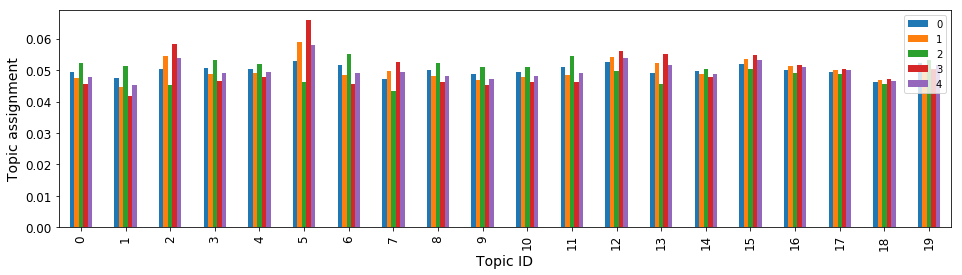

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

# Model Exploration

***Note: The following section is meant as a deeper dive into exploring the trained models. The demonstrated functionalities may not be fully supported or guaranteed. For example, the parameter names may change without notice.***


The trained model artifact is a compressed package of MXNet models from the two workers. To explore the model, we first need to install mxnet.

In [61]:
# If you use conda_mxnet_p36 kernel, mxnet is already installed, otherwise, uncomment the following line to install.
# !pip install mxnet 
import mxnet as mx

Here we download unpack the artifact

In [62]:
print(output_prefix)

amazonreview/output


In [63]:
import os
import shutil

#model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
#model_path = 's3://pilho-sagemaker-ai-workshop/amazonreview/output/ntm-2018-07-27-06-43-35-098/output/model.tar.gz'
#model_path = '/amazonreview/output/ntm-2018-07-27-06-43-35-098/output/model.tar.gz'
model_path = os.path.join(output_prefix, 'ntm-2018-08-03-02-14-58-933/output/model.tar.gz')
model_path

'amazonreview/output/ntm-2018-08-03-02-14-58-933/output/model.tar.gz'

In [64]:
#boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')
boto3.resource('s3').meta.client.download_file('pilho-sagemaker-ai-workshop','amazonreview/output/ntm-2018-07-27-06-43-35-098/output/model.tar.gz', 'downloaded_model.tar.gz')


In [65]:
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [66]:
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


We can load the model parameters and extract the weight matrix $W$ in the decoder as follows

In [67]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

Matrix $W$ corresponds to the $W$ in the NTM digram at the beginning of this notebook. Each column of $W$ corresponds to a learned topic. The elements in the columns of $W$ corresponds to the pseudo-probability of a word within a topic. We can visualize each topic as a word cloud with the size of each word be proportional to the pseudo-probability of the words appearing under each topic.

In [68]:
!pip install wordcloud
import wordcloud as wc

mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


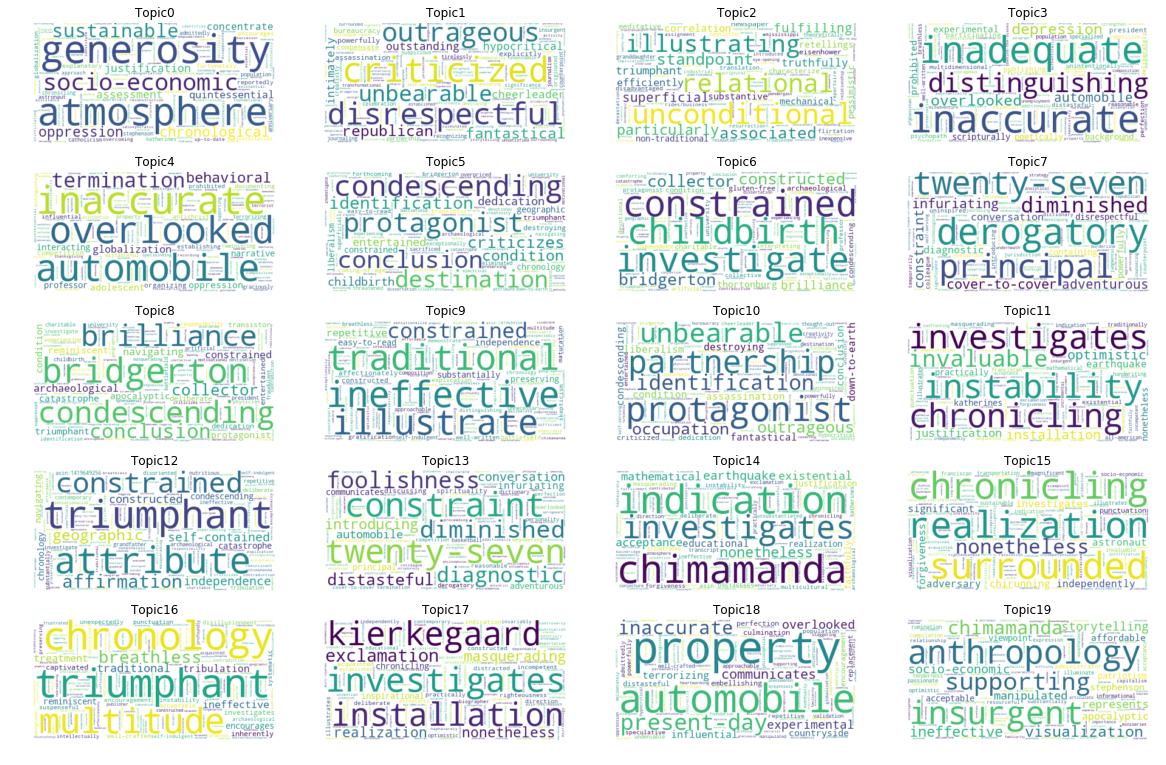

In [69]:
!pip install wordcloud
import wordcloud as wc

word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1

## Compute topics using Kmeans

Let's try the other method called Kmeans to clusgter documents into N clusters based on their TFIDF similarity. Within each cluster, we will count the top occuring terms.

In [68]:
import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()

tfidf_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english',
                            tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)

tfidf_vectors = tfidf_vectorizer.fit_transform(raveld_source_data)
tfidf_vocab_list = tfidf_vectorizer.get_feature_names()
print('vocab size:', len(tfidf_vocab_list))

# random shuffle
idx = np.arange(tfidf_vectors.shape[0])
np.random.shuffle(idx)
tfidf_vectors = tfidf_vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...
vocab size: 2000
Done. Time elapsed: 11.66s


In [69]:
print(tfidf_vectors.shape)

(10000, 2000)


In [70]:
print(tfidf_vectors[0])

  (0, 670)	1.0


Because all the parameters (weights and biases) in the Kmeans model are `np.float32` type we'd need the input data to also be in `np.float32`. It is better to do this type-casting upfront rather than repeatedly casting during mini-batch training.

In [72]:
tfidf_vectors = tfidf_vectors.astype('float32')
print(tfidf_vectors.shape)

(10000, 2000)


In [73]:
n_tfidf_train = int(0.8 * tfidf_vectors.shape[0])

# split train and test
tfidf_train_vectors = tfidf_vectors[:n_tfidf_train, :]
tfidf_test_vectors = tfidf_vectors[n_tfidf_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_tfidf_test = tfidf_test_vectors.shape[0]
tfidf_val_vectors = tfidf_test_vectors[:n_tfidf_test//2, :]
tfidf_test_vectors = tfidf_test_vectors[n_tfidf_test//2:, :]

In [74]:
print(tfidf_train_vectors.shape, tfidf_test_vectors.shape, tfidf_val_vectors.shape)

(8000, 2000) (1000, 2000) (1000, 2000)


In [75]:
import io
import numpy as np
import sagemaker.amazon.common as smac
import boto3
import os

#trainVectors = np.array([t.tolist() for t in train_X]).astype('float32')
#trainLabels = np.where(np.array([t.tolist() for t in train_y]) == 0, 1, 0).astype('float32')

bucket = 'pilho-sagemaker-ai-workshop'
prefix = 'amazonreview/kmeans'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_kmean_train_data = os.path.join('s3://', bucket, train_prefix)
s3_kmean_val_data = os.path.join('s3://', bucket, val_prefix)
output_kmean_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_kmean_train_data)
print('Validation set location', s3_kmean_val_data)
print('Trained model will be saved at', output_kmean_path)

Training set location s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train
Validation set location s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/val
Trained model will be saved at s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/output


In [76]:
split_convert_upload(tfidf_train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(tfidf_val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part0.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part1.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part2.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part3.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part4.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part5.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part6.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/train/train_part7.pbr
Uploaded data to s3://pilho-sagemaker-ai-workshop/amazonreview/kmeans/val/val_part0.pbr


## Kmeans Model Training

We have created the training and validation data sets and uploaded them to S3. Next, we configure a SageMaker training job to use the Kmeans algorithm on the data we prepared.

In [77]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'kmeans')

In [78]:
import sagemaker
sess = sagemaker.Session()
kmeans = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=2, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

In [79]:
num_topics = 20
kmeans.set_hyperparameters(k=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        extra_center_factor='auto')

In [80]:
from sagemaker.session import s3_input
s3_train = s3_input(s3_kmean_train_data, distribution='ShardedByS3Key') 

In [81]:
kmeans.fit({'train': s3_train, 'test': s3_val_data})

INFO:sagemaker:Creating training-job with name: kmeans-2018-08-06-13-51-53-543


.......................
Docker entrypoint called with argument(s): train
[08/06/2018 13:55:32 INFO 140617011492672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[08/06/2018 13:55:32 INFO 140617011492672] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'2000', u'mini_batch_size': u'128', u'k': u'20', u'extra_center_factor': u'auto'}
[08/06/2018 13:55:32 INFO 140617011492

===== Job Complete =====
Billable seconds: 203


In [82]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-08-06-13-59-25-672
INFO:sagemaker:Creating endpoint with name kmeans-2018-08-06-13-51-53-543


----------------------------------------------------------------!CPU times: user 256 ms, sys: 16 ms, total: 272 ms
Wall time: 5min 24s


---
Below parts are to be converted to work with SageMaker's 1st-party algorithms.

## Show cluster top 15 words per topic
Using the approach [outlined in the sklearn documentation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html), we first extract the top 15 stemmed words per topic in our LDA model. As a second step, we do something similar for our kmeans clustered documents. Here we just count the top 15 most frequent stemmed words per cluster. Both show similar sets of results.

In [14]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()
    
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()
    
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 15)

Top 15 stemmed words per topic in LDA model

Topic #0:
god, mani, histori, american, world, polit, christian, author, life, church, state, present, centuri, view, live
Topic #1:
br, s, war, peopl, becaus, men, life, page, onli, women, histori, human, whi, t, world
Topic #2:
love, great, book, beauti, illustr, color, art, page, pictur, movi, littl, children, nice, wonder, stori
Topic #3:
excel, condit, comic, great, thank, ship, describ, cd, photograph, lesson, servic, killer, militari, multipl, fast
Topic #4:
book, veri, just, like, good, guy, know, travel, dog, want, place, wasn't, littl, fan, receiv
Topic #5:
book, read, veri, good, like, great, just, realli, time, use, don't, look, page, i'm, want
Topic #6:
recip, food, game, husband, cook, thorough, make, eat, famili, cookbook, fan, tri, home, potenti, year
Topic #7:
book, use, help, work, inform, understand, chapter, studi, need, learn, provid, recommend, guid, practic, mani
Topic #8:
die, la, presid, film, harri, s, b, und, d, r,

In [15]:
print("Top 15 stemmed words per cluster in Kmeans model\n")
show_cluster_topics(kmean_d, tfidf_d, tfidf_m.get_feature_names(), 15)

Top 15 stemmed words per cluster in Kmeans model

Cluster #0:
br, book, read, stori, like, love, time, just, life, author, charact, work, veri, make, way
Cluster #1:
good, veri, book, read, condit, inform, stori, qualiti, great, realli, school, price, easi, refer, ship
Cluster #2:
excel, condit, book, read, servic, price, product, trilog, fast, refer, great, arriv, good, inform, qualiti
Cluster #3:
read, stori, book, charact, enjoy, like, novel, time, seri, love, end, just, great, author, life
Cluster #4:
love, book, grandson, daughter, seri, read, old, great, son, year, gift, stori, kid, time, bought
Cluster #5:
book, great, use, work, good, just, time, read, help, like, recip, inform, need, gift, make
Cluster #6:
veri, book, inform, read, great, good, easi, help, written, nice, recommend, happi, time, love, use
Cluster #7:
thank, describ, ship, great, fast, condit, book, exact, outstand, work, excel, arriv, wonder, product, perfect
Cluster #8:
book, read, great, recommend, realli, li

## Prepare data for plotting
Our TF/TFIDF matricies are thousands of attributes wide which makes it a challenge to graphically represent documents as we are limited to 3 dimensions. We could perform a heirarchical clustering, but the number of documents makes this approach very slow. Instead, we perform a SVD/LSA to reduce the dimensionality of the matrix to something more manageable (eg. 30 dimensions).

We then use t-SNE to attempt to visually cluster and represent our data as best as possible in 2 dimensions. More information about t-SNE can be found at [Laurens van der Maaten's site](https://lvdmaaten.github.io/tsne/). In the end we will have a 2 dimensional matrix for our XY plot. Be sure to read the [caveats of t-SNE plots](http://distill.pub/2016/misread-tsne/) as well.

Our Kmeans output already has cluster labels in it (eg. one cluster label per document). However LDA allows for a single document to cover multiple topics. One approach could be to perform a clustering on top of the LDA output. But for this example, I chose the dominant topic for each document as its label in the LDA model.

In [16]:
def get_svd(data, components):
    svd = TruncatedSVD(n_components=components).fit(data)
    o = pd.DataFrame(svd.transform(data), columns=range(0,components))
    return svd,o

def get_tsne(data, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

## Plot Data
Here we use our LDA and Kmeans labels with our reduced dimensions to plot our documents. We create a rainbow color scheme which allows for a variable number of topics/clusters. You could choose any other color map which suits your needs. I chose to plot this in 2D, however you could create 3 TSNE dimensions in the step above and create a 3D scatterplot as well. 

The plot tends to overlap quite a bit. If you sample through some of the reviews you'll see many tend to use similar wording.

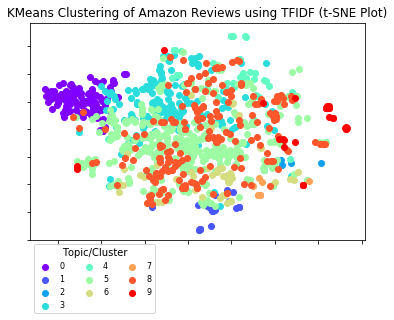

In [17]:
def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Amazon Reviews using TFIDF (t-SNE Plot)')

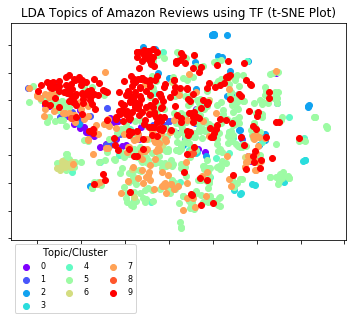

In [18]:
%matplotlib inline
plot_scatter_2d(tsne_m[0], tsne_m[1], lda_c, 1000, 'LDA Topics of Amazon Reviews using TF (t-SNE Plot)')

## Prepare data for rating prediction
The previous steps allowed us to understand how the data is structured, but it doesn't let us understand what drives positive or negative reviews. In the next steps, we look at the words within reviews to build a predictive scoring model. 

When training these types of models, overfitting can occur where we become very good at predicting our sample data, but fail to predict on new data. To avoid this, we split the data 70%/30% where we reserve the 30% for gauging our final accuracy.

We will build 3 models. One that predicts low, one that predicts high, and one that predicts neutral. For each review, we run it against all three models. The model that scores the highest will tell us which kind of review it likely is.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d, source_data['rate_category'], test_size=0.3)

In [20]:
print(X_test, y_test)

  (0, 3857)	0.21147692000300233
  (0, 1553)	0.1979037768051097
  (0, 1227)	0.20808944668126417
  (0, 3860)	0.14886225527037525
  (0, 645)	0.2010071091109698
  (0, 3739)	0.16396136475095535
  (0, 475)	0.19716574515195806
  (0, 291)	0.20619219236925135
  (0, 1811)	0.4498382058850176
  (0, 1712)	0.2845235165901404
  (0, 3120)	0.35185907944261224
  (0, 2291)	0.09906631970320365
  (0, 61)	0.18549666820359142
  (0, 4103)	0.11415715727238537
  (0, 1457)	0.150770025032341
  (0, 3104)	0.2055801240457653
  (0, 761)	0.16295198022275048
  (0, 1723)	0.09380155875928137
  (0, 2338)	0.1970896858500072
  (0, 349)	0.12668495217349188
  (0, 1309)	0.12227811828306209
  (0, 383)	0.14287694376084892
  (0, 444)	0.21679430473354183
  (1, 3924)	0.08576792655783548
  (1, 4318)	0.09715351097007915
  :	:
  (2997, 2690)	0.2541389881593213
  (2997, 288)	0.2243240796501294
  (2997, 3785)	0.28139892067013905
  (2997, 748)	0.26169752290969023
  (2997, 2520)	0.2824056080659292
  (2997, 3156)	0.18839581384143206
  (299

## Calculate model accuracies
We try 3 different approaches to building the review predictions: Logistic Regression, Naive Bayes, and Support Vector Machines. We also try a final approach that does a combined "vote" of all three models. This means we are actually building (4 approaches) x (3 ratings) = 12 total models. Since we have limited data, we will use cross-validation to split the data 10 ways and measure accuracy in an unbiased way.

The accuracy % are printed below for each model.

In [21]:
cat = ['negative','neutral','positive']

def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in cat:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocess

Model accuracy predictions

LR model (negative rating): 90.2%
LR model (neutral rating): 93.0%
LR model (positive rating): 84.2%

SVM model (negative rating): 91.1%
SVM model (neutral rating): 92.7%
SVM model (positive rating): 85.6%

NB model (negative rating): 90.2%
NB model (neutral rating): 93.0%
NB model (positive rating): 83.2%

COMBINED model (negative rating): 90.2%
COMBINED model (neutral rating): 93.0%
COMBINED model (positive rating): 84.2%



/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/preprocess

## Training the model of choice
All models seem to have done roughly the same on low and neutral rating reviews. SVM seems to have given better performance for our 4-5 star reviews. There is definitely room for improvement. The distribution of the stratified raiting buckets were 33% each. 

If we guessed each review's status at random, that would be our % likelihood of guessing correct. Our three models show quite an improvement over random guessing, but still opportunity to improve. There are lots of ways to tweak the prior steps to get a better result. 
- We didn't tweak any parameters in either the TF step or the modeling step
- Neg/Pos keywords might vary by topic so we might do this for one cluster at a time
- Maybe nouns don't provide much insight and we are better off removing them
- "great" and "not great" have opposite meanings so maybe we should have included 2-grams

The list goes on, but I think you get the idea. The next steps just assume we are happy with our logistic regression model.

In [22]:
def get_lr(x, y):
    models = []
    for c in cat:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

## Plot the results
The following three charts show the result of our Logistic Regression model. We show the top 12 words **negatively associated (red)** with that review model, and the top 12 words **positively associated (green)** with that review model. Roughly speaking, the values indiciate how much more likely or unlikely a review is to be low, neutral, high given the # of times that word occurs in the review.

In the first example, "review" has a very high likelihood of predicting a low review. Remember that words are stemmed so "easi" could refer to words like "easy, easier, easiest". We clearly see negative words associated with our negative model, and positive words with our positive model. Interestingly, the neutral reviews have words I'd consider as being unsure.


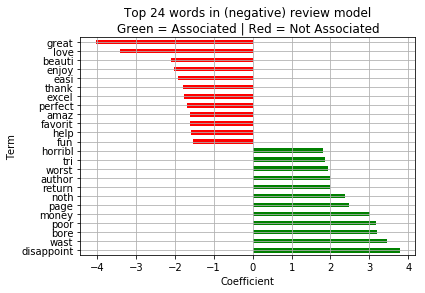

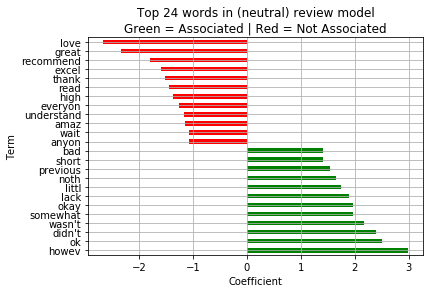

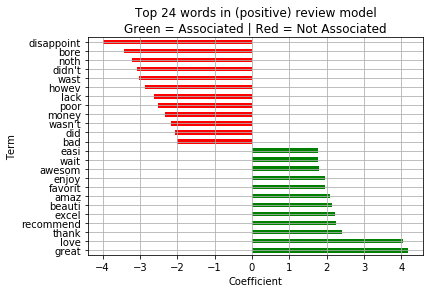

In [23]:
%matplotlib inline

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

n_terms = 12
for c in range(0,len(cat)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=cat[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)


## Test output
To put it altogether, below is a test function which allows you to supply your own review to see how well the model will predict it's rating. For simplicity, I stuck with the logistic regression model and only allow for one review at a time. 

The program uses the stored TFIDF matrix to tokenize and transform our new review which is then fed to all three of our logistic regression models. Each model has an independent assessment of how likely it is that our review is a positive hit. You could set some sort of threshold or take the model with the higest likelihood to make your determination.

In [24]:
def test_review(text):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Predction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=cat[m], P=lr_m[m].predict_proba(test_new)[0][1]))

In [25]:
test_review('They arrived damaged.')

Review text: "They arrived damaged."

Model Predction
Model (negative): 8.2%
Model (neutral): 5.0%
Model (positive): 87.4%


In [26]:
test_review('This is the best toaster oven I have ever owned! I am glad I bought it.')

Review text: "This is the best toaster oven I have ever owned! I am glad I bought it."

Model Predction
Model (negative): 3.1%
Model (neutral): 8.4%
Model (positive): 90.8%


# References

* Original Jupyter Notebook: https://github.com/zuenko/python/blob/4db739a658a550cfebbc4930002d925777f2edf4/yanix/Contest/ML_track/AmazonReview.ipynb